# Постановка задачи
Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.
* Оцените корректность проведения теста
* Проанализируйте результаты теста

Чтобы оценить корректность проведения теста, проверьте:
* пересечение тестовой аудитории с конкурирующим тестом,
* совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

# Техническое задание
* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.
    
Загрузите данные теста, проверьте корректность его проведения и проанализируйте полученные результаты.

# Описание данных
Таблица ab_marketing_events — календарь маркетинговых событий на 2020 год;

* name — название маркетингового события;
* regions — регионы, в которых будет проводиться рекламная кампания;
* start_dt — дата начала кампании;
* finish_dt — дата завершения кампании.

Таблица ab_new_users — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

* user_id — идентификатор пользователя;
* first_date — дата регистрации;
* region — регион пользователя;
* device — устройство, с которого происходила регистрация.

Таблица ab_events — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

* user_id — идентификатор пользователя;
* event_dt — дата и время события;
* event_name — тип события;
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

Таблица ab_participants — таблица участников тестов.

* user_id — идентификатор пользователя;
* ab_test — название теста;
* group — группа пользователя.

# Инструкция по выполнению проекта
# Шаг 1. Загрузка данных и подготовка к анализу
* 1.1. Импорт библиотек и загрузка данных.
* 1.2. Осмотр данных.
* 1.3. Выводы о данных.
* 1.4. Предобработка таблицы ab_marketing_events — календарь маркетинговых событий на 2020 год.
* 1.5. Предобработка таблицы ab_new_users — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.
* 1.6. Предобработка таблицы ab_events — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
* 1.7. Выводы о предобработки данных.
# Шаг 2. Исследовательский анализ данных
* 2.1. Посмотрим календарь маркетинговых событий на 2020 год.
* 2.2. Проанализируем данные о пользователях, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.
* 2.3. Проанализируем данные о событиях, где все события новых пользователей за период с 7 декабря 2020 по 4 января 2021 года.
* 2.4. Посмотрим таблицу с участниками тестов. Сравним группы.
# Шаг 3. Исследуем конверсию в воронке на разных этапах
* 3.1. Посчитаем сколько пользователей совершали каждое из событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
* 3.2. Построим воронку событий.
* 3.3. Построим воронку с учетом последовательности событий.
# Шаг 4. Проведем оценку результатов A/B-тестирования
* 4.1. Проверим статистическую разницу долей по этапам с помощью z-критерия между выборками группы А и группы В.
# Шаг 5. Общие выводы

## Шаг. Загрузка данных и подготовка к анализу
### Импорт библиотек и загрузка данных.

In [80]:
# Необходимые библиотеки для исследования.
import pandas as pd                                         # для анализа данных
import numpy as np                                          # для математических вычислений
import math as mth                                          # для математических вычислений

import seaborn as sns                                       # для визуализации данных
import matplotlib.pyplot as plt                             # для визуализации
import plotly.express as px                                 # для визуализации
from plotly import graph_objects as go                      # для визуализации

import datetime as dt                                       # для преобразования к типу данных 'дата'
import requests                                             # для HTTP запросов
import re                                                   # для работы с регулярными выражениями

from datetime import datetime, timedelta

import scipy.stats as stats
from scipy import stats as st                               # для высокоуровневых математических вычислений 
from statsmodels.stats.proportion import proportions_ztest  # статистика пропорции z-тест, метод статистической проверки гипотез

import warnings                                             # для предупреждений в программе 
warnings.filterwarnings('ignore')                           # фильтр предупреждений

In [81]:
# Загрузка данных.
ab_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv') # календарь маркетинговых событий на 2020 год
ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv') # все пользователи с 7 декабря по 21 декабря 2020 года
ab_events = pd.read_csv('/datasets/final_ab_events.csv') # события новых пользователей с 7 декабря 2020 по 4 января 2021 года
ab_participants = pd.read_csv('/datasets/final_ab_participants.csv') # таблица участников тестов 

In [82]:
# С помощью pd.set_option настроим вывод так чтобы
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', -1) # текст в ячейке отражался полностью вне зависимости от длины;
pd.set_option('display.float_format', '{:.2f}'.format) # все числа отражались с двумя знаками после запятой.

In [83]:
# Установка единого стиля палитры для всех графиков.
sns.set_style('whitegrid')
sns.set_palette('spring_r')

###  Осмотр данных.

In [84]:
# Напишем функцию для получения информации о датасетах
def info_about_dataframe(dataframe):
    print("Получение 10 случайно выбранных записей из таблицы:")
    display(dataframe.sample(10, random_state=123))
    print("Выведем статистику о датасете:")
    display(dataframe.describe())
    print("Получение общей информации о данных в таблице:")
    dataframe.info()
    missing_values = dataframe.isnull().sum().sum()
    duplicates = dataframe.duplicated().sum()
    print()
    print("Количество пропущенных значений: {} строк".format(missing_values)) 
    print("Доля пропущенных значений от общего количества записей: {:.1%}".format((missing_values/len(dataframe)))) 
    print("Количество дубликатов: {} строк".format(duplicates))              
    print("Доля дубликатов от общего количества записей: {:.1%}".format((duplicates/len(dataframe)))) 

Рассмотрим таблицу ab_marketing_events о календаре маркетинговых событий на 2020 год.

In [85]:
info_about_dataframe(ab_marketing_events) # календарь маркетинговых событий на 2020 год

Получение 10 случайно выбранных записей из таблицы:


,name,regions,start_dt,finish_dt
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
4,4th of July Promo,N.America,2020-07-04,2020-07-11
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


Выведем статистику о датасете:


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Dragon Boat Festival Giveaway,APAC,2020-03-08,2020-11-12
freq,1,4,1,1


Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes

Количество пропущенных значений: 0 строк
Доля пропущенных значений от общего количества записей: 0.0%
Количество дубликатов: 0 строк
Доля дубликатов от общего количества записей: 0.0%


* Всего в таблице 14 строк (наблюдений) и 4 столбца, встречаются следующие типы данных: object (строки).
* Некорректный тип в дате и времени start_dt и finish_dt.
* Варьируется регистр букв в name и regions.

Рассмотрим таблицу ab_new_users о пользователях с 7 декабря по 21 декабря 2020 года.

In [86]:
info_about_dataframe(ab_new_users) # все пользователи с 7 декабря по 21 декабря 2020 года

Получение 10 случайно выбранных записей из таблицы:


,user_id,first_date,region,device
25384,A6F33BAF22C58324,2020-12-22,EU,Android
50810,4AE6BE5D4A945F9B,2020-12-19,EU,PC
2632,894E24B4CAD43DD0,2020-12-07,EU,PC
15749,4D3BB93DF5170FCD,2020-12-21,EU,Android
23229,1142E0F7944D24AE,2020-12-15,CIS,iPhone
21418,B29261E1FD3F69D2,2020-12-15,CIS,Android
40096,BB388853D574ED34,2020-12-11,EU,Mac
60490,9F17DAA9F8821330,2020-12-20,EU,Android
8749,716BE60CC73439C5,2020-12-14,EU,Android
6474,DDAFBE7625C4662F,2020-12-14,EU,Android


Выведем статистику о датасете:


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,0E8BFC85EDCD672B,2020-12-21,EU,Android
freq,1,6290,46270,27520


Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB

Количество пропущенных значений: 0 строк
Доля пропущенных значений от общего количества записей: 0.0%
Количество дубликатов: 0 строк
Доля дубликатов от общего количества записей: 0.0%


* Всего в таблице 61733 строк (наблюдений) и 4 столбца, встречаются следующие типы данных: object (строки).
* Некорректный тип в дате и времени first_date.
* Варьируется регистр букв в region и device.

Рассмотрим таблицу ab_events о событиях новых пользователей с 7 декабря 2020 по 4 января 2021 года.

In [87]:
info_about_dataframe(ab_events) # события новых пользователей с 7 декабря 2020 по 4 января 2021 года

Получение 10 случайно выбранных записей из таблицы:


,user_id,event_dt,event_name,details
185080,404C3593F5E1F39E,2020-12-18 18:28:03,product_page,nan
406109,64BF6D4DC706004C,2020-12-24 16:00:57,login,nan
264749,573EF5CB449265BE,2020-12-09 03:33:16,login,nan
384828,7632283393859D01,2020-12-22 19:13:50,login,nan
152724,F21EAB3C6A438427,2020-12-13 12:04:50,product_page,nan
339730,CC75CEEC5BBB65F3,2020-12-18 01:53:27,login,nan
130363,A00223825AB51ED0,2020-12-08 21:19:00,product_page,nan
325832,6A0BDC2EC052DA05,2020-12-17 02:58:32,login,nan
404763,9B5F8F6B7D78DF9D,2020-12-24 07:40:13,login,nan
257157,7AECCD5B5E1DF650,2020-12-08 00:25:46,login,nan


Выведем статистику о датасете:


,details
count,62740.00
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB

Количество пропущенных значений: 377577 строк
Доля пропущенных значений от общего количества записей: 85.8%
Количество дубликатов: 0 строк
Доля дубликатов от общего количества записей: 0.0%


* Всего в таблице 440317 строк (наблюдений) и 4 столбца, встречаются следующие типы данных: object (строки) и float64 (вещественные числа).
* Количество пропущенных значений: 377577 строк, 85,8% от общего количества записей датасета, это очень много.
* Некорректный тип в дате и времени event_dt.

Рассмотрим таблицу ab_participants о участниках тестов.

In [88]:
info_about_dataframe(ab_participants) # таблица участников тестов 

Получение 10 случайно выбранных записей из таблицы:


,user_id,group,ab_test
12671,48CFE37563932DC2,B,interface_eu_test
6424,CB62A54028D1FF6C,A,recommender_system_test
1992,7BCB5C914C255ED8,B,recommender_system_test
1483,5CEE54AF7967ABB0,B,recommender_system_test
16096,B299698A26DB338A,B,interface_eu_test
11229,DC0DE566EA049A38,A,interface_eu_test
854,A4593845C28990A0,B,recommender_system_test
17351,0323461CB86778B4,A,interface_eu_test
8016,9F7B59660B1AAF35,A,interface_eu_test
11164,B51EEE76990E6163,B,interface_eu_test


Выведем статистику о датасете:


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,7F2C298110AA73B4,A,interface_eu_test
freq,2,9655,11567


Получение общей информации о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB

Количество пропущенных значений: 0 строк
Доля пропущенных значений от общего количества записей: 0.0%
Количество дубликатов: 0 строк
Доля дубликатов от общего количества записей: 0.0%


* Всего в таблице 18268 строк (наблюдений) и 3 столбца, встречаются следующие типы данных: object (строки).

### Выводы о данных.

Наблюдаю следующие проблемы с данными:

* В таблице ab_marketing_events: некорректный тип в дате и времени 'start_dt' и 'finish_dt'; варьируется регистр букв в 'name' и 'regions'.
* В таблице ab_new_users: некорректный тип в дате и времени 'first_date'; варьируется регистр букв в 'region' и 'device'.
* В таблице ab_events: в столбце 'details' количество пропущенных значений: 377577 строк; некорректный тип в дате и времени 'event_dt'.

В таблице ab_participants: здесь все ок.

### Предобработка таблицы ab_marketing_events — календарь маркетинговых событий на 2020 год.

In [89]:
# замена типа данных на datetime
ab_marketing_events['start_dt'] = pd.to_datetime(ab_marketing_events['start_dt'])
ab_marketing_events['finish_dt'] = pd.to_datetime(ab_marketing_events['finish_dt'])

In [90]:
# переименуем столбцы для удобства дальнейшей работы
ab_marketing_events.rename(columns={'start_dt': 'start_date', 
                                    'finish_dt': 'finish_date'}, inplace=True) 
ab_marketing_events.columns.tolist() # проверка результатов

['name', 'regions', 'start_date', 'finish_date']

In [91]:
# приведем строки к нижнему регистру
ab_marketing_events['name'] = ab_marketing_events['name'].str.lower()
ab_marketing_events['regions'] = ab_marketing_events['regions'].str.lower()

In [92]:
ab_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name           14 non-null object
regions        14 non-null object
start_date     14 non-null datetime64[ns]
finish_date    14 non-null datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


### Предобработка таблицы ab_new_users — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.

In [93]:
# замена типа данных на datetime
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])

In [94]:
# приведем строки к нижнему регистру
ab_new_users['device'] = ab_new_users['device'].str.lower()
ab_new_users['region'] = ab_new_users['region'].str.lower()

In [95]:
ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null datetime64[ns]
region        61733 non-null object
device        61733 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


### Предобработка таблицы ab_events — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [96]:
# замена типа данных на datetime
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [97]:
# переименуем столбец для удобства дальнейшей работы
ab_events.rename(columns={'event_dt': 'event_date'}, inplace=True) 

In [98]:
ab_events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [99]:
ab_events['details'].isna().sum()

377577

Заметка: данные отсутствуют потому что, не было дополнительной информации о событие. В этом случае правильно оставить эти значения пустыми. Отсутствие значения — тоже важный сигнал, который не нужно прятать.

In [100]:
ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_date    440317 non-null datetime64[ns]
event_name    440317 non-null object
details       62740 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


### Выводы о предобработки данных.

* В таблице ab_marketing_events:
    * привели даты в столбцах 'start_dt' и 'finish_dt' к типу datetime;
    * переименовали столбцы для удобства дальнейшей работы {'start_dt': 'start_date', 'finish_dt': 'finish_date'};
    * привели строки к нижнему регистру в столбцах 'name' и 'regions'.
* В таблице ab_new_users:
    * привели даты в столбце 'first_date' к типу datetime;
    * привели строки к нижнему регистру в столбцах 'region' и 'device'.
* В таблице ab_events:
    * привели даты в столбце 'event_dt' к типу datetime;
    * переименовали столбец для удобства дальнейшей работы {'event_dt': 'event_date'};
    * в столбце 'details' количество пропущенных значений 377577 строк, удалять или заменять мы их не стали, так как данные отсутствуют потому что, не было дополнительной информации о событие. В этом случае правильно оставить эти значения пустыми.

Названия столбцов и их тип данных теперь корректны и удобны для дальнейшей работы. Их исправление позволит провести анализ точнее.

## Шаг. Исследовательский анализ данных

### Посмотрим календарь маркетинговых событий на 2020 год.

In [101]:
# Посмотрим на таблицу.
ab_marketing_events.sort_values(by='start_date', ascending=True)

,name,regions,start_date,finish_date
6,chinese new year promo,apac,2020-01-25,2020-02-07
1,st. valentine's day giveaway,"eu, cis, apac, n.america",2020-02-14,2020-02-16
8,international women's day promo,"eu, cis, apac",2020-03-08,2020-03-10
2,st. patric's day promo,"eu, n.america",2020-03-17,2020-03-19
3,easter promo,"eu, cis, apac, n.america",2020-04-12,2020-04-19
7,labor day (may 1st) ads campaign,"eu, cis, apac",2020-05-01,2020-05-03
9,victory day cis (may 9th) event,cis,2020-05-09,2020-05-11
11,dragon boat festival giveaway,apac,2020-06-25,2020-07-01
4,4th of july promo,n.america,2020-07-04,2020-07-11
13,chinese moon festival,apac,2020-10-01,2020-10-07


По техническому заданию, далее ТЗ, нам необходимы данные только с 7 декабря 2020 по 4 января 2021 года. Отфильтруем датасет на нужные даты.

In [102]:
# отфильтруем датасет на нужные даты
ab_marketing_events = ab_marketing_events[(ab_marketing_events['start_date'] <= "2021-01-04") & 
                                          (ab_marketing_events['finish_date'] >= "2020-12-07")]
ab_marketing_events

,name,regions,start_date,finish_date
0,christmas&new year promo,"eu, n.america",2020-12-25,2021-01-03
10,cis new year gift lottery,cis,2020-12-30,2021-01-07


Выводы:

В этот период есть 2 маркетинговых события. Они и будут влиять на активность пользователей.

Где,

* christmas&new year promo = рождественский и новогодний промо в Европе и Северной Америке
* cis new year gift lottery = лотерея подарков на новый год в СНГ

### Проанализируем данные о пользователях, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.

In [103]:
# Посмотрим на таблицу.
ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,eu,pc
1,F1C668619DFE6E65,2020-12-07,n.america,android
2,2E1BF1D4C37EA01F,2020-12-07,eu,pc
3,50734A22C0C63768,2020-12-07,eu,iphone
4,E1BDDCE0DAFA2679,2020-12-07,n.america,iphone


In [104]:
# Посчитаем общее кол-во пользователей.
users_total = len(ab_new_users['user_id'].unique())
print("Всего пользователей в логе: {} пользователей".format(users_total))

Всего пользователей в логе: 61733 пользователей


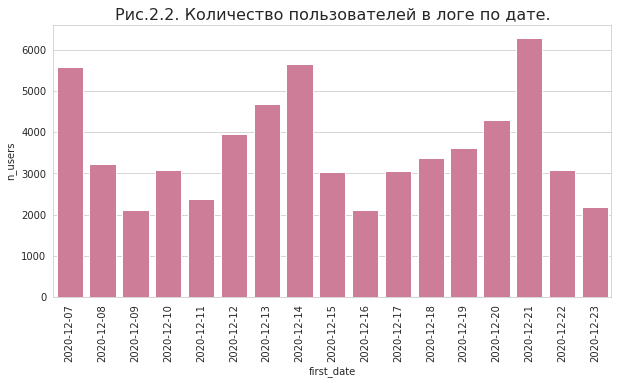

In [105]:
# Сгруппируем данные по полю first_date (дата регистрации) и посчитаем количество уникальных пользователей.
users_count = ab_new_users.groupby('first_date').agg({'user_id': ['nunique']}).reset_index()
users_count.columns = ['first_date', 'n_users']

# Применим метод dt.strftime() — он превращает объект Series с типом datetime в строку в формате даты. 
users_count['first_date'] = users_count['first_date'].dt.strftime('%Y-%m-%d')

# Строим график.
plt.figure(figsize=(10,5))
plt.title('Рис.2.2. Количество пользователей в логе по дате.', fontsize=16) 
sns.barplot(x='first_date', y='n_users', data=users_count, color='#DB7093') #orient='h'
plt.xticks(rotation= 90)
plt.show()

По условиям ТЗ дата остановки набора новых пользователей 21-12-2020. Уберем пользователей зарегистрировавшихся после 21 декабря.

In [106]:
# Оставим пользователей до 21-12-2020.
ab_new_users = ab_new_users.query('first_date <= "2020-12-21"')

# Найдем минимальную и максимальную дату.
min_first_date = ab_new_users['first_date'].min()
max_first_date = ab_new_users['first_date'].max()

print("Дата первой записи в логе после фильтрации:: {} ".format(min_first_date))
print("Дата последней записи в логе после фильтрации:: {} ".format(max_first_date))
print("Период ведения лога после фильтрации: {} ".format(max_first_date - min_first_date))

Дата первой записи в логе после фильтрации:: 2020-12-07 00:00:00 
Дата последней записи в логе после фильтрации:: 2020-12-21 00:00:00 
Период ведения лога после фильтрации: 14 days 00:00:00 


In [107]:
# Посчитаем общее кол-во пользователей после фильтрации.
users_total = len(ab_new_users['user_id'].unique())
print("Всего пользователей в логе после фильтрации: {} пользователей".format(users_total))

Всего пользователей в логе после фильтрации: 56470 пользователей


Посмотрим из каких регионов пользователи и какими устройствами они пользуются.

In [108]:
# Вызовем к столбцу 'region' и 'device' метод value_counts(), который возвращает уникальные значения и количество их упоминаний.
display(ab_new_users['region'].value_counts())
display(ab_new_users['device'].value_counts())

eu           42340
n.america    8347 
cis          2900 
apac         2883 
Name: region, dtype: int64

android    25161
pc         14310
iphone     11477
mac        5522 
Name: device, dtype: int64

Выводы:

В логе с новыми пользователями за период с 7-12-2020 по 21-12-2020:
* всего пользователей 56470
* из региона eu (европа) = 42340 пользователей
* из региона n.america (северная америка) = 8347 пользователей
* из региона cis (содружество независимых государств) = 2900 пользователей
* из региона apac (азиатско-тихоокеанский регион) = 2883 пользователя
* большинство пользователей использую платформы от microsoft
* меньшинство пользователей использую платформы от apple

### Проанализируем данные о событиях, где все события новых пользователей за период с 7 декабря 2020 по 4 января 2021 года.

In [109]:
# Посмотрим на таблицу.
ab_events.head()

,user_id,event_date,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [110]:
# Посчитаем общее кол-во событий.
events_total = len(ab_events)
print("Всего событий в логе: {} событий".format(events_total))

# Посчитаем общее кол-во пользователей.
users_events_total = len(ab_events['user_id'].unique())
print("Всего пользователей в логе: {} пользователей".format(users_events_total))
print("В среднем на одного пользователя приходится: {} событий".format(round(events_total/users_events_total)))

Всего событий в логе: 440317 событий
Всего пользователей в логе: 58703 пользователей
В среднем на одного пользователя приходится: 8 событий


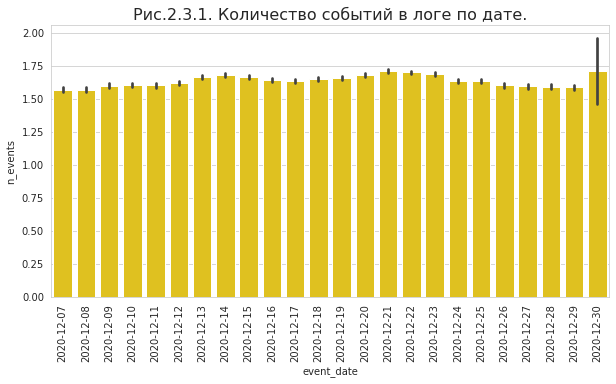

In [111]:
# Сгруппируем данные по полю event_date и посчитаем количество событий.
events_date_count = ab_events.groupby('event_date').agg({'event_name': ['count']}).reset_index()
events_date_count.columns = ['event_date', 'n_events']

# Применим метод dt.strftime() — он превращает объект Series с типом datetime в строку в формате даты. 
events_date_count['event_date'] = events_date_count['event_date'].dt.strftime('%Y-%m-%d')

# Строим график.
plt.figure(figsize=(10,5))
plt.title('Рис.2.3.1. Количество событий в логе по дате.', fontsize=16) 
sns.barplot(x='event_date', y='n_events', data=events_date_count, color="#FFD700") #orient='h'
plt.xticks(rotation= 90)
plt.show()

По графику видим, что после 29-12-2020 данные неполные. По ТЗ для тестирования нам необходимы полные данные до 2021-01-04. Видимо произошел какой-то сбой в записи событий. Не будем учитывать неполные данные после 29-12-2020, и отсеем их.

In [112]:
# Отфильтруем данные, оставим до 29-12-2020.
ab_events = ab_events.query('event_date <= "2020-12-29"')

In [113]:
# Посчитаем общее кол-во событий после фильтрации.
events_total = len(ab_events)
print("Всего событий в логе после фильтрации: {} событий".format(events_total))

# Посчитаем общее кол-во пользователей после фильтрации.
users_events_total = len(ab_events['user_id'].unique())
print("Всего пользователей в логе после фильтрации: {} пользователей".format(users_events_total))
print("В среднем на одного пользователя приходится после фильтрации: {} событий".format(
    int(ab_events.groupby('user_id').agg({'event_name':'count'})['event_name'].mean())))

Всего событий в логе после фильтрации: 430082 событий
Всего пользователей в логе после фильтрации: 58702 пользователей
В среднем на одного пользователя приходится после фильтрации: 7 событий


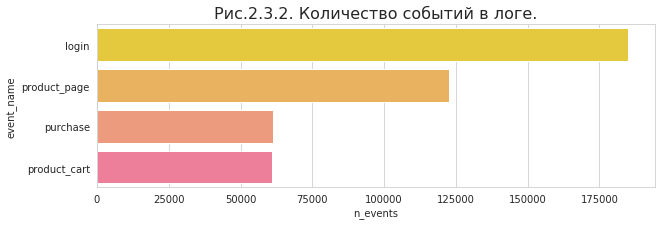

,event_name,n_events,ratio_events
0,login,185129,43.00
2,product_page,122669,28.50
3,purchase,61301,14.30
1,product_cart,60983,14.20


In [114]:
# Методом groupby() сгруппируем по событию и посчитаем кол-во записей для каждого события.
events_count = ab_events.groupby('event_name').agg({'event_date':'count'})\
                                             .reset_index().sort_values(by='event_date', ascending=False)
events_count.columns = ['event_name', 'n_events']

# Доля событий от общего кол-ва. 
events_count['ratio_events'] = ((events_count['n_events'] / events_count['n_events'].sum()) * 100).round(1)

# Строим график с помощью SEABORN.
plt.figure(figsize=(10, 3))
plt.title('Рис.2.3.2. Количество событий в логе.', fontsize=16) 
sns.barplot(x='n_events', y='event_name', data=events_count)
plt.show()
events_count

Выводы:

* Всего событий в логе после фильтрации: 430082 событий
* Всего пользователей в логе после фильтрации: 58702 пользователей
* В среднем на одного пользователя приходится после фильтрации: 7 событий

4 отслеживаемых событий:
* (1) login = логин (вход в систему) чаще всего вызываемое событие в приложении, 185129 раз;
* (2) product_page = страница продукта, вызываемое событие 122669 раз;
* (3) purchase = покупка (кол-во покупок), вызываемое событие 61301 раз;
* (4) product_cart = корзина продукта, вызываемое событие 60983 раз; меньше всего взаимодействий с корзиной.

318 пользователей переходят сразу на оплату, в обход корзины.

### Посмотрим таблицу с участниками тестов. Сравним группы.

In [115]:
# Посмотрим на таблицу.
ab_participants.sample(10)

,user_id,group,ab_test
4125,998F4E1FD24A2BF3,A,recommender_system_test
13216,6C6022BBA51A3C40,A,interface_eu_test
6060,F7166A10FF980198,B,recommender_system_test
508,0D53336168AE6BF5,B,recommender_system_test
1412,44807382F18F0AE9,B,recommender_system_test
3583,2E53814463A4BE74,A,recommender_system_test
7491,9431D6C9475CFD3A,B,interface_eu_test
9602,519A3A75ECFCE532,A,interface_eu_test
5959,D5C08FF7A81F5A18,A,recommender_system_test
4658,F46FE699C8997D7B,B,recommender_system_test


In [116]:
# Посчитаем общее кол-во пользователей.
users_total = len(ab_participants['user_id'].unique())
print("Всего пользователей в логе: {} пользователей".format(users_total))

# Сгруппируем данные по полю ab_test и group, и посчитаем количество уникальных пользователей.
ab_test_groups_count = ab_participants.groupby(['ab_test', 'group']).agg({'user_id':'nunique'})
ab_test_groups_count

Всего пользователей в логе: 16666 пользователей


user_id
ab_test                 group         
interface_eu_test       A      5831   
                        B      5736   
recommender_system_test A      3824   
                        B      2877

Есть два теста interface_eu_test и recommender_system_test.

In [117]:
# Посмотрим пересечение тестовой аудитории с конкурирующим тестом.
len(ab_participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test == 2'))

1602

1602 пользователя участвовало в двух тестах одновременно.

В техническом задании написано, что нас интересует тест recommender_system_test. Отфильтруем таблицу по необходимому нам тесту для исследования.

In [118]:
# отфильтруем таблицу по необходимому нам тесту для исследования
ab_participants = ab_participants.query('ab_test == "recommender_system_test"')

In [119]:
# проверим результат
len(ab_participants.groupby('user_id').agg({'group':'nunique'}).query('group == 2'))

0

,group,n_users
0,A,3824
1,B,2877


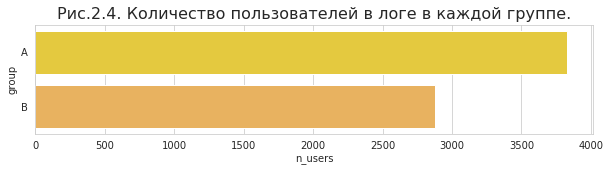

In [120]:
# Сгруппируем данные по полю group и посчитаем количество уникальных пользователей.
group_users_count = ab_participants.groupby('group').agg({'user_id': ['nunique']})\
                                        .reset_index().sort_values(by= ('user_id', 'nunique'), ascending=False)
group_users_count.columns = ['group', 'n_users']
display(group_users_count)
# Строим график.
plt.figure(figsize=(10,2))
plt.title('Рис.2.4. Количество пользователей в логе в каждой группе.', fontsize=16) 
sns.barplot(x='n_users', y='group', data=group_users_count, orient='h')
plt.show()

In [121]:
# Посчитаем общее кол-во пользователей после фильтрации.
users_total = len(ab_participants['user_id'].unique())
print("Всего пользователей в логе после фильтрации: {} пользователей".format(users_total))

Всего пользователей в логе после фильтрации: 6701 пользователей


Выводы:

В тесте recommender_system_test:
* Группа: А (контрольная): 3824 пользователей
* Группа: B (новая платёжная воронка): 2877 пользователей

По ТЗ 15% новых пользователей должны быть из региона EU. Нужно убедиться, что в выборку попало 15% новых пользователей из региона EU.

In [122]:
# Посчитаем количество всех новых пользователей из EU.
ab_new_users_eu = len(ab_new_users.query('region == "eu"')) 

# Соединим таблицы 'ab_participants' и 'ab_new_users' по 'user_id'. НОВАЯ ТАБЛИЦА
ab_test_data = pd.merge(ab_participants, ab_new_users, on='user_id') 

# Найдем аудиторию из EU.
objective_users = ab_test_data.groupby('region').agg({'user_id':'nunique'}).loc['eu', 'user_id']
x = objective_users/ab_new_users_eu
print("% новых пользователей из региона EU: {:.0%}".format(x))

% новых пользователей из региона EU: 15%


Убедились, что в выборку попало 15% новых пользователей из региона EU.

### Сравним группы

In [123]:
# Добавим к данным с участниками тестов информацию о событиях.
ab_test_data = pd.merge(ab_test_data, ab_events, on='user_id')

In [124]:
# Сравним группы А и В.
group_A = ab_test_data.query('group == "A"')
group_B = ab_test_data.query('group == "B"')

Обладают ли выборки одинаковыми распределениями количества событий на пользователя?

In [125]:
# Добавим среднее количество событий на пользователя.
event_mean_A = group_A.pivot_table(index=['user_id', 'event_name'], values='event_date', aggfunc='count').reset_index()\
                      .groupby('event_name').agg({'event_date':'mean'}).reset_index().round(2)
event_mean_A.columns = ['event_name', 'event_mean_A']
display("Cреднее количество событий на пользователя группы А")
display(event_mean_A)

event_mean_B = group_B.pivot_table(index=['user_id', 'event_name'], values='event_date', aggfunc='count').reset_index()\
                      .groupby('event_name').agg({'event_date':'mean'}).reset_index().round(2)
event_mean_B.columns = ['event_name', 'event_mean_B']
display("Cреднее количество событий на пользователя группы В")
display(event_mean_B)

'Cреднее количество событий на пользователя группы А'

,event_name,event_mean_A
0,login,3.05
1,product_cart,3.04
2,product_page,3.03
3,purchase,2.99


'Cреднее количество событий на пользователя группы В'

,event_name,event_mean_B
0,login,2.78
1,product_cart,2.67
2,product_page,2.65
3,purchase,2.59


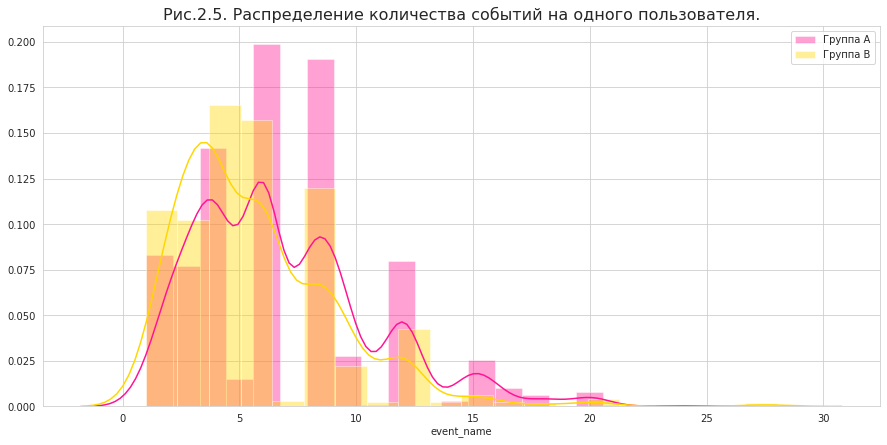

In [126]:
event_per_user_A = group_A.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
event_per_user_B = group_B.pivot_table(index=['user_id'],values='event_name',aggfunc='count').reset_index()
# Строим график.
plt.figure(figsize=(15, 7))
sns.distplot(event_per_user_A['event_name'], bins=20, color = 'DeepPink')
sns.distplot(event_per_user_B['event_name'], bins=20, color = 'Gold')
plt.legend(labels = ('Группа A', 'Группа B'))
plt.title('Рис.2.5. Распределение количества событий на одного пользователя.', fontsize=16)
plt.show()

Выводы;

Видно, что среднее число взаимодействий на одного пользователя у группы А лучше, чем в группе В. Группы обладают различным распределением взаимодействий, и разными средним количеством событий на одного пользователя.

## Шаг. Исследуем конверсию в воронке на разных этапах

### Посчитаем сколько пользователей совершали каждое из событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [127]:
# Посмотрим нашу новую таблицу. 
ab_test_data.head()

,user_id,group,ab_test,first_date,region,device,event_date,event_name,details
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,eu,pc,2020-12-07 14:43:27,purchase,99.99
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,eu,pc,2020-12-25 00:04:56,purchase,4.99
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,eu,pc,2020-12-07 14:43:29,product_cart,nan
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,eu,pc,2020-12-25 00:04:57,product_cart,nan
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,eu,pc,2020-12-07 14:43:27,product_page,nan


In [128]:
ab_test_data.user_id.nunique()

3675

In [129]:
# Посчитаем общее кол-во пользователей.
users_total_filtered = len(ab_test_data['user_id'].unique())
print("Всего пользователей в логе: {} пользователей".format(users_total_filtered))

Всего пользователей в логе: 3675 пользователей


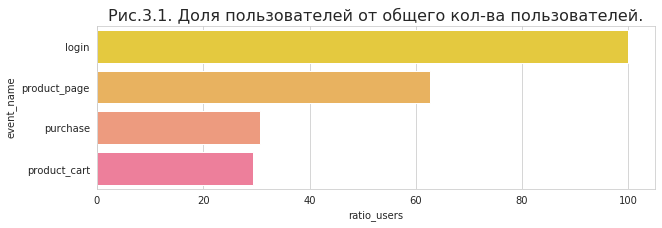

,event_name,n_users,ratio_users
0,login,3675,100.00
2,product_page,2303,62.70
3,purchase,1128,30.70
1,product_cart,1079,29.40


In [130]:
# Сгруппируем данные из ab_events по полю event_name и посчитаем количество уникальных пользователей.
users_events_filtered = ab_test_data.groupby('event_name').agg({'user_id': 'nunique'})\
                                    .reset_index().sort_values(by='user_id', ascending=False)
users_events_filtered.columns = ['event_name', 'n_users']

# Доля пользователей от общего кол-ва пользователей, которые хоть раз совершали событие. 
users_events_filtered['ratio_users'] = ((users_events_filtered['n_users'] / users_total_filtered) * 100).round(1)
                                                                                                        
# Строим график.
plt.figure(figsize=(10,3))
plt.title('Рис.3.1. Доля пользователей от общего кол-ва пользователей.', fontsize=16) 
sns.barplot(x='ratio_users', y='event_name', data=users_events_filtered, orient='h')
plt.show()
users_events_filtered

Выводы:

* Cобытие login, было совершено в 100% случаев, это очень хорошо. Здесь не обнаружили проблем.
* Половина пользователей совершает покупку сразу со страницы товара, в обход корзины.

4 отслеживаемых событий:
* (1) login = логин (вход в систему)
* (2) product_page = страница продукта,
* (3) product_cart = корзина продукта
* (4) purchase = покупка

### Построим воронку событий.

In [131]:
# Построим воронку событий.
fig = go.Figure(go.Funnel(
    y = users_events_filtered["event_name"],
    x = users_events_filtered["n_users"],
    textposition = "inside",
    textinfo = "value + percent previous + percent initial",
    opacity = 0.90, marker = {"color": ["gold", "coral", "lightcoral", "lightpink"]})
    )
fig.update_layout(title="Рис.3.2. Воронка событий.")
fig.show()

Выводы:

Дойдя до страницы purchase, 50% пользователей производят оплату сразу, в обход корзины.

### Построим воронку с учетом последовательности событий.

По ТЗ ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%: product_page → product_card → purchase

То есть, следующая последовательность событий:
* (1) login = логин (вход в систему)
* (2) product_page = страница продукта,
* (3) product_cart = корзина продукта
* (4) purchase = покупка

In [132]:
# Для пользователей посчитаем время первого срабатывания каждого события методом pivot_table().
users_data = ab_test_data.pivot_table(index='user_id', columns='event_name', values='event_date', aggfunc='min')

# Узнаем, сколько пользователей переходило с этапа на этап.   
login = ~users_data['login'].isna()
product_page = login & (users_data['product_page'] > users_data['login'])
product_cart = product_page & (users_data['product_cart'] > users_data['product_page'])
purchase = product_cart & (users_data['purchase'] > users_data['product_cart'])

n_login = users_data[login].shape[0]
n_product_page = users_data[product_page].shape[0]
n_product_cart = users_data[product_cart].shape[0]
n_purchase = users_data[purchase].shape[0]

print("Вошли в систему: {} пользователей".format(n_login))
print("Перешли на страницу с продуктом: {} пользователей".format(n_product_page))
print("Перешли на экран с корзиной продукта: {} пользователей".format(n_product_cart))
print("Перешли на экран с покупкой: {} пользователей".format(n_purchase))

Вошли в систему: 3675 пользователей
Перешли на страницу с продуктом: 1296 пользователей
Перешли на экран с корзиной продукта: 77 пользователей
Перешли на экран с покупкой: 1 пользователей


In [133]:
# Доля пользователей от общего кол-ва пользователей, которая проходит на следующий шаг воронки. 
users_events_filtered['funnel_events'] = [n_login, n_product_page, n_purchase, n_product_cart]
users_events_filtered['ratio_funnel'] = ((users_events_filtered['funnel_events'] / users_total_filtered) * 100).round(1)
users_events_filtered

,event_name,n_users,ratio_users,funnel_events,ratio_funnel
0,login,3675,100.00,3675,100.00
2,product_page,2303,62.70,1296,35.30
3,purchase,1128,30.70,1,0.00
1,product_cart,1079,29.40,77,2.10


In [141]:
ab_test_data.groupby('event_name').agg(user_count=('user_id','nunique')).reset_index()

,event_name,user_count
0,login,3674
1,product_cart,1079
2,product_page,2303
3,purchase,1128


In [142]:
funnel = ab_test_data.groupby('event_name').agg(user_count=('user_id','nunique')).reset_index()
funnel = funnel.reindex([0, 2, 1,3])

fig = go.Figure(
    go.Funnel(
        y=funnel['event_name'] ,
        x=funnel['user_count'] ,
        textinfo = "value+percent initial",
        hoverinfo = "percent previous",
        opacity = 0.7, marker = {"color": ["#008ab9", "#00ade7", "#45d0ff", "#a2e7ff"]},
        
        ))
fig.update_layout(title="Рис.3.3. Воронка с учётом последовательности событий.")
fig.show()

In [144]:
# Доля пользователей, которая доходит от первого события до оплаты.
users_events_filtered.query('event_name == "purchase"')

,event_name,n_users,ratio_users,funnel_events,ratio_funnel
3,purchase,1128,30.70,1,0.00


Выводы:

В воронке с учетом последовательности событий больше всего пользователей теряем на этапе покупка.

От первого события до оплаты доходит 29,4% пользователей. Но с учетом последовательности событий 0%.

В ТЗ написано что, на каждом из шагов воронки product_page → product_card → purchase улучшение составит не менее 10%. В нашем случае нет воронки, нет улучшения конверсии в воронке.

## Шаг. Проведем оценку результатов A/B-тестирования

### Проверим статистическую разницу долей по этапам с помощью z-критерия между выборками группы А и группы В.

Группы: А (контрольная), B (новая платёжная воронка). Импортировала новую библиотеку proportions_ztest, для создания упрощенной формы функции для проверки гипотез.

In [145]:
# Посмотрим новую таблицу. 
ab_test_data.sample(5)

,user_id,group,ab_test,first_date,region,device,event_date,event_name,details
3245,BA9E68C3B8270A6C,A,recommender_system_test,2020-12-15,eu,pc,2020-12-25 19:46:25,purchase,4.99
2193,B3E321BBB0EB332B,A,recommender_system_test,2020-12-07,eu,android,2020-12-07 07:47:12,product_page,nan
14931,903B7FB3C9AB7B72,A,recommender_system_test,2020-12-17,eu,iphone,2020-12-17 11:30:44,product_page,nan
12610,31EA3C7FC0132A9E,A,recommender_system_test,2020-12-09,eu,android,2020-12-09 20:00:00,login,nan
13179,833B123682A99117,A,recommender_system_test,2020-12-07,eu,android,2020-12-12 03:03:41,login,nan


In [146]:
# Генерируем две независимые выборки группа А и группа В.

# контрольная группа А:
group_A = ab_test_data.query('group == "A"') # создадим отдельную таблицу по группе А
exp_А = group_A.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by='user_id', ascending = False)\
                       .reset_index() # построим воронку событий для группы А

exp_А.columns = ['event_name', 'n_users'] # назовем столбцы 'название события' и 'кол-во уникальных пользователей' 
exp_А['total_users'] = len(group_A['user_id'].unique()) # столбец с общим кол-вом уникальных пользователей в группе 
exp_А['ratio'] = (exp_А['n_users'] / exp_А['total_users']* 100).round(1) # доля пользователей совершивших событие 
exp_А

,event_name,n_users,total_users,ratio
0,login,2747,2747,100.00
1,product_page,1780,2747,64.80
2,purchase,872,2747,31.70
3,product_cart,824,2747,30.00


In [147]:
# экспериментальная группа В:
group_B = ab_test_data.query('group == "B"') # создадим отдельную таблицу по группе В
exp_В = group_B.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)\
                       .reset_index() # построим воронку событий для группы В

exp_В.columns = ['event_name', 'n_users'] # назовем столбцы 'название события' и 'кол-во уникальных пользователей' 
exp_В['total_users'] = len(group_B['user_id'].unique()) # столбец с общим кол-вом уникальных пользователей в группе
exp_В['ratio'] = (exp_В['n_users'] / exp_В['total_users']* 100).round(1) # доля пользователей совершивших событие 
exp_В

,event_name,n_users,total_users,ratio
0,login,927,928,99.90
1,product_page,523,928,56.40
2,purchase,256,928,27.60
3,product_cart,255,928,27.50


Сформулируем нулевую и альтернативную гипотезы:
* Нулевая гипотеза H₀: Конверсия в покупателей между выборками одинаковые.
* Альтернативная гипотеза H₁: Конверсия в покупателей между выборками разные.

In [148]:
# Создадим функцию, которая будет брать на вход строку и сравнивать четыре значения.
alpha = 0.05 # критический уровень статистической значимости

# в функцию будем передавать кол-во пользователей в каждой группе совершивших определенное событие 
# и общее количество пользователей в группе
def p_value(row): 
    successes = np.array([row['n_users_A'], row['n_users_B']]) # кол-во уникальных пользователей определенного события
    trials = np.array([row['total_users_A'], row['total_users_B']]) # общее кол-во уникальных пользователей 
    stat, pval = proportions_ztest(successes, trials) 
    return pval

# в функцию будем передавать полученное p-value и сравнивать его с уровнем критической значимости
# функция будет возврващать результат
def result(row, coefficient):
    pval = row['p-value'] # столбец с p-значением из z-теста
    if (pval < coefficient):
        return("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        return("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.")

Сравним доли конверсий в группах А и В между собой для всех событий.

In [149]:
# Сравним доли конверсий в группах А и В между собой для всех событий.
ab_exp = exp_А.merge(exp_В, on='event_name', suffixes=('_A', '_B'))

# Добавим результат работы функции в отдельный столбец.
ab_exp['p-value'] = ab_exp.apply(p_value, axis=1)
ab_exp['result'] = ab_exp.apply(result, coefficient=alpha, axis=1)
ab_exp

,event_name,n_users_A,total_users_A,ratio_A,n_users_B,total_users_B,ratio_B,p-value,result
0,login,2747,2747,100.00,927,928,99.90,0.09,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными."
1,product_page,1780,2747,64.80,523,928,56.40,0.00,Отвергаем нулевую гипотезу: между долями есть значимая разница
2,purchase,872,2747,31.70,256,928,27.60,0.02,Отвергаем нулевую гипотезу: между долями есть значимая разница
3,product_cart,824,2747,30.00,255,928,27.50,0.15,"Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными."


Выводы:

Между группами А и В статистическая значимость различий достигнута для события "product_page" и "purchase", появление страницы продукта и покупки. Для остальных нет статистически значимой разницы между группами.

## Шаг. Общие выводы

ПО РЕЗУЛЬТАТАМ ИССЛЕДОВАНИЯ, ДАННЫЕ В ТЗ НЕКОРРЕКТНЫ ПО СЛЕДУЮЩИМ ПУНКТАМ:

* в файле final_ab_new_users.csv с новыми пользователями, дата остановки набора новых пользователей была 23-12-2020, а не 2020-12-21. было больше данных;
* в файле final_ab_events.csv с событиями, данные оборвались на 30-12-2020 года, были не полными, а должны были быть до 4-01-2021. Видимо произошел какой-то сбой в записи событий.

Также, обнаружили следующее:

* что 318 пользователей переходят сразу на оплату, в обход корзины;
* что 1602 пользователя участвовало в двух тестах одновременно;
* что группы обладают различным распределением взаимодействий, и разными средним количеством событий на одного пользователя.

ПО ИЗУЧЕНИЮ ВОРОНКИ С УЧЕТОМ ПОСЛЕДОВАТЕЛЬНОСТИ СОБЫТИЙ:

* больше всего пользователей теряли на этапе покупки;
* от первого события до оплаты доходит 33,3% пользователей. но с учетом последовательности событий 0%;
* в тз написано, что, на каждом из шагов воронки product_page → product_card → purchase улучшение составит не менее 10%. в этом случае воронка событий не получилась, поэтому нет улучшения конверсии в ней;
* также, обнаружили, что многие пользователи не входили в систему (не регистрировались), а сразу покупали. что негативно повлияло на воронку.

ПО ОЦЕНКЕ РЕЗУЛЬТАТОВ A/B-ТЕСТИРОВАНИЯ: тест лучше остановить и признать провальным. Видим, что по целевым признакам product_page и purchase есть статистически значимая разница между группами. Изменения, связанные с внедрением улучшенной рекомендательной системы, показали себя не очень хорошо.

РЕКОМЕНДАЦИИ: необходимо решить проблемы с воронкой событий и провести тест заново.